# Churn Prediction with PySpark using MLlib and ML Packages

Churn prediction is big business. It minimizes customer defection by predicting which customers are likely to cancel a subscription to a service. Though originally used within the telecommunications industry, it has become common practice across banks, ISPs, insurance firms, and other verticals

In [1]:
#disable the warnings
import warnings
warnings.filterwarnings('ignore')

#set matplotlib inline
%matplotlib inline
import pandas as pd
#pd.options.display.mpl_style = 'default'

For this tutorial, we'll be using the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not. 

We have two sets of data from the same batch,splitted by an 80/20 ratio.We wil use the larger set for training an cross-validtion purposes, and the smaller set for final testing and model performance evaluation.

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession


spark = SparkSession\
        .builder\
        .appName("Churn_Preddiction")\
        .config('spark.sql.warehouse.dir','file:///home/sudipto21048867/Pyspark/spark-warehouse')\
        .getOrCreate()

In [3]:
CV_data = spark.read.csv('/user/sudipto21048867/data/churn_data/churn-bigml-80.csv' , header='true', inferSchema='true')

In [4]:
CV_data.show(5)

+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|State|Account length|Area code|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total day charge|Total eve minutes|Total eve calls|Total eve charge|Total night minutes|Total night calls|Total night charge|Total intl minutes|Total intl calls|Total intl charge|Customer service calls|Churn|
+-----+--------------+---------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+----------------------+-----+
|   

In [5]:
final_test_data = spark.read.csv('/user/sudipto21048867/data/churn_data/churn-bigml-20.csv',header=True,inferSchema=True)


In [6]:
CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [7]:
#We use Pandas instead of the Spark DataFrame.show() function because it creates a prettier print

pd.DataFrame(CV_data.take(5),columns=CV_data.columns).transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


# Summary Statistics

In [8]:
CV_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64
Total eve minutes,2666,200.38615903976006,50.95151511764598,0.0,363.7
Total eve calls,2666,100.02363090772693,20.16144511531889,0,170
Total eve charge,2666,17.033072018004518,4.330864176799864,0.0,30.91


# Correlations and Data Preparation

We will use Pandas library to examine correlations between numeric columnsby generating scatter plots of them

For the Pandas workload, we don't want to pull the entire data set into the Spark driver, as that might exhaust the available RAM and throw an out-of-memory exception. Instead, we'll randomly sample a portion of the data (say 10%) to get a rough idea of how it looks.

In [9]:
CV_data.dtypes

[('State', 'string'),
 ('Account length', 'int'),
 ('Area code', 'int'),
 ('International plan', 'string'),
 ('Voice mail plan', 'string'),
 ('Number vmail messages', 'int'),
 ('Total day minutes', 'double'),
 ('Total day calls', 'int'),
 ('Total day charge', 'double'),
 ('Total eve minutes', 'double'),
 ('Total eve calls', 'int'),
 ('Total eve charge', 'double'),
 ('Total night minutes', 'double'),
 ('Total night calls', 'int'),
 ('Total night charge', 'double'),
 ('Total intl minutes', 'double'),
 ('Total intl calls', 'int'),
 ('Total intl charge', 'double'),
 ('Customer service calls', 'int'),
 ('Churn', 'boolean')]

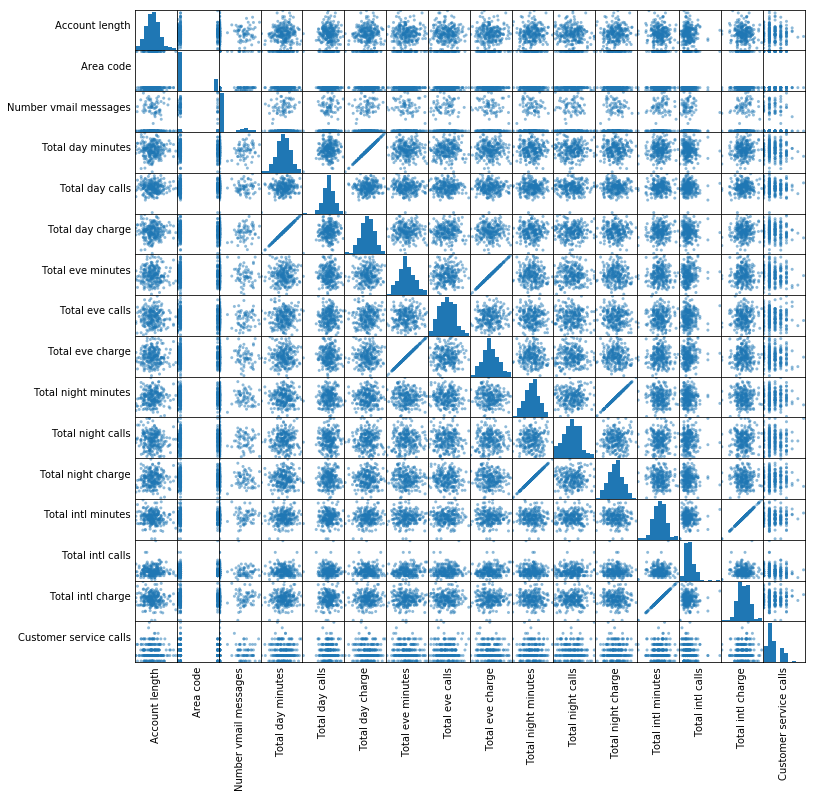

In [10]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It's obvious that there are several highly correlated fields, ie Total day minutes and Total day charge. Such correlated data won't be very beneficial for our model training runs, so we're going to remove them. We'll do so by dropping one column of each pair of correlated fields, along with the State and Area code columns.

While we're in the process of manipulating the data sets, let's transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes/True and No/False to 1 and 0, respectively.

In [11]:
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

binary_map = {'Yes':1.0, 'No':0.0, True : 1.0, False :0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(CV_data['Churn'])) \
    .withColumn('International plan', toNum(CV_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(CV_data['Voice mail plan'])).cache()

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge') \
    .withColumn('Churn', toNum(final_test_data['Churn'])) \
    .withColumn('International plan', toNum(final_test_data['International plan'])) \
    .withColumn('Voice mail plan', toNum(final_test_data['Voice mail plan'])).cache()

Let's take a quick look at the resulting dataset

In [13]:
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


# Model Training

MLlib classifiers and regressors require data sets in a format of rows of type LabeledPoint, which separates row labels and feature lists, and names them accordingly. The custom labelData() function shown below performs the row parsing. We'll pass it the prepared data set (CV_data) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a maxDepth of 2, to build a "shallow" tree. The tree depth can be regarded as an indicator of model complexity.

In [15]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

print model.toDebugString()

DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 4 <= 264.3)
   If (feature 12 <= 3.0)
    Predict: 0.0
   Else (feature 12 > 3.0)
    Predict: 0.0
  Else (feature 4 > 264.3)
   If (feature 2 in {1.0})
    Predict: 0.0
   Else (feature 2 not in {1.0})
    Predict: 1.0



The toDebugString() function provides a print of the tree's decision nodes and final prediction outcomes at the end leafs. We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn. It's not surprising that these feature numbers map to the fields Customer service calls and Total day minutes. Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

In [16]:
print 'Feature 12:', CV_data.columns[12]
print 'Feature 4: ', CV_data.columns[4]

Feature 12: Customer service calls
Feature 4:  Total day minutes


# Model Evaluation

Predictions of the testing data's churn outcome are made with the model's predict() function and grouped together with the actual churn label of each customer data using getPredictionsLabels().

We'll use MLlib's MulticlassMetrics() for the model evaluation, which takes rows of (prediction, label) tuples as input. It provides metrics such as precision, recall, F1 score and confusion matrix, which have been bundled for printing with the custom printMetrics() function.

In [17]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print 'Precision of True ', metrics.precision(1)
    print 'Precision of False', metrics.precision(0)
    print 'Recall of True    ', metrics.recall(1)
    print 'Recall of False   ', metrics.recall(0)
    print 'F-1 Score         ', metrics.fMeasure()
    print 'Confusion Matrix\n', metrics.confusionMatrix().toArray()

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)


Precision of True  0.863636363636
Precision of False 0.863387978142
Recall of True     0.202127659574
Recall of False    0.993710691824
F-1 Score          0.863397548161
Confusion Matrix
[[ 474.    3.]
 [  75.   19.]]


The overall accuracy, ie F-1 score, seems quite good, but one troubling issue is the discrepancy between the recall measures. The recall (aka sensitivity) for the Churn=False samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, we need to ensure that our model is sensitive to the Churn=True samples.

Perhaps the model's sensitivity bias toward Churn=False samples is due to a skewed distribution of the two types of samples. Let's try grouping the CV_data DataFrame by the Churn field and counting the number of instances in each group.

In [18]:
CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,2278
1,1.0,388


# Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. We can put the two sample types on the same footing using stratified sampling. The DataFrames sampleBy() function does this when provided with fractions of each sample type to be returned.

Here we're keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 388/2278.

In [19]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: 388./2278, 1: 1.0}).cache()

stratified_CV_data.groupby('Churn').count().toPandas()

,Churn,count
0,0.0,364
1,1.0,388


Let's build a new model using the evenly distributed data set and see how it performs.

In [20]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

Precision of True  0.760563380282
Precision of False 0.717171717172
Recall of True     0.658536585366
Recall of False    0.806818181818
F-1 Score          0.735294117647
Confusion Matrix
[[ 71.  17.]
 [ 28.  54.]]
